# StyleGAN2

This notebook demonstrates how to run NVIDIA's StyleGAN2 on Google Colab.
Make sure to specify a GPU runtime.

This notebook mainly adds a few convenience functions. 

For information on StyleGAN2, see:

Paper: https://arxiv.org/abs/1812.04948

Video: https://youtu.be/kSLJriaOumA

Code: https://github.com/NVlabs/stylegan

FFHQ: https://github.com/NVlabs/ffhq-dataset

/Mikael Christensen, 2019.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
!git clone https://github.com/cedricoeldorf/ConditionalStyleGAN.git
%cd ConditionalStyleGAN
!nvcc test_nvcc.cu -o test_nvcc -run

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))
tf.compat.v1.Session(
    target='', graph=None, config=None
)

TensorFlow 1.x selected.
Cloning into 'ConditionalStyleGAN'...
remote: Enumerating objects: 99, done.
remote: Total 99 (delta 0), reused 0 (delta 0), pack-reused 99
Unpacking objects: 100% (99/99), done.
/content/ConditionalStyleGAN
gcc: error: test_nvcc.cu: No such file or directory
gcc: warning: ‘-x c++’ after last input file has no effect
gcc: fatal error: no input files
compilation terminated.
Tensorflow version: 1.15.2
GPU 0: Tesla T4 (UUID: GPU-0e14a4c7-76be-07ca-4dfb-07589f58180b)
GPU Identified at: /device:GPU:0


In [12]:
# Download the model of choice
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import pickle

v = tf.Variable(10, name="v")
sess = tf.InteractiveSession()
sess.run(v.initializer)
print(v.eval())
# import pretrained_networks

# Choose between these pretrained models - I think 'f' is the best choice:

# 1024×1024 faces
# stylegan2-ffhq-config-a.pkl
# stylegan2-ffhq-config-b.pkl
# stylegan2-ffhq-config-c.pkl
# stylegan2-ffhq-config-d.pkl
# stylegan2-ffhq-config-e.pkl
# stylegan2-ffhq-config-f.pkl

# 512×384 cars
# stylegan2-car-config-a.pkl
# stylegan2-car-config-b.pkl
# stylegan2-car-config-c.pkl
# stylegan2-car-config-d.pkl
# stylegan2-car-config-e.pkl
# stylegan2-car-config-f.pkl

# 256x256 horses
# stylegan2-horse-config-a.pkl
# stylegan2-horse-config-f.pkl

# 256x256 churches
# stylegan2-church-config-a.pkl
# stylegan2-church-config-f.pkl

# 256x256 cats
# stylegan2-cat-config-f.pkl
# stylegan2-cat-config-a.pkl
network_pkl = "/content/drive/MyDrive/network-snapshot-014800.pkl"

# If downloads fails, due to 'Google Drive download quota exceeded' you can try downloading manually from your own Google Drive account
# network_pkl = "/content/drive/My Drive/GAN/stylegan2-ffhq-config-f.pkl"


print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pickle.load(open(network_pkl, 'rb'))
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

10
Loading networks from "/content/drive/MyDrive/network-snapshot-014800.pkl"...







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )





[1714016 9471740 3092094 8140093 7240975 6145715 5490489 2557347 9917244
 3355700 6443410  427898 5296006 1956271 3706604 4561136 4549659  587072
 9059899  870121 7203298 3451684  999830  930265 6559501 4238175 5601804
 2276366 3189938 7980124 2666534 2579893 4258750 7069334 1466600 3417924
 2097986  571037  698063 5156399 3094918 3218234 1138981 2171980 9879338
 1128945 7224323 8110684 1872825 8582702 3073540 4647225 5011565 5468647
 1933596 9639531 9293424 2500956 6531261 6759922 9320003  493526 5498776
 8568450 3310363 3997720 3056043 4464315 3570033 3236630 3885118 7969696
 7755071 9145385 7164780 5796323  813814 9893146 6937481 5835801 3818342
   21078 2912088 1760919 2518167 2089647 8857947 1483614 2151239 1730545
 6501832 9103235 8194712 1584849 2595666 3481850 9542652 4482418 1045034
  267375]


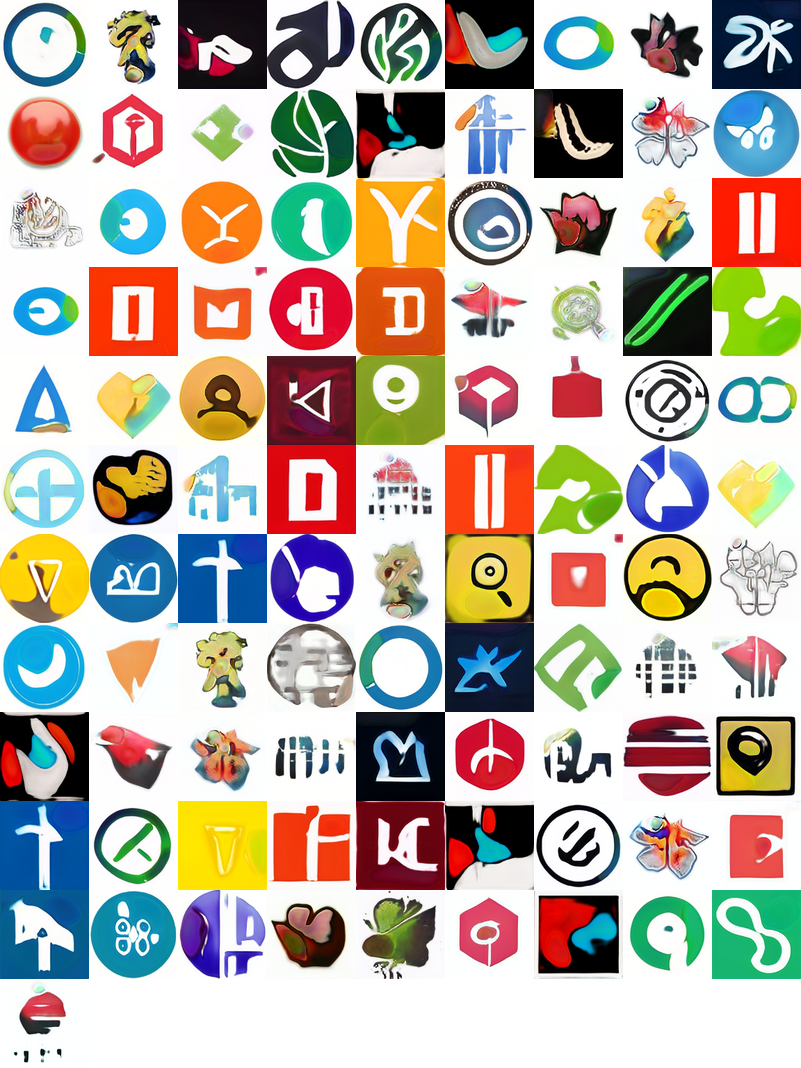

In [15]:
# generate some random seeds
seeds = np.random.randint(10000000, size=100)
print(seeds)

# show the seeds
imshow(createImageGrid(generate_images_from_seeds(seeds, 0.7), 0.7 , 12))

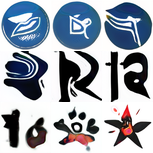

In [16]:
# Simple (Z) interpolation
zs = generate_zs_from_seeds([5015289 , 9148088 ])

latent1 = zs[0]
latent2 = zs[1]

number_of_steps = 9

imgs = generate_images(interpolate([latent1,latent2],number_of_steps), 1.0)
number_of_images = len(imgs)
imshow(createImageGrid(imgs, 0.4 , 3))